# 5. Defining the threshold with simulated data
Now that we have the main statistics for each variable, we will use simulated data to find the optimal threshold for the interval regarding the mean of the variable `FUEL_ERROR_DIFF`. We will aim to minimize the false negatives (leaks that we don't detect) without increasing the false positives (no leaks that we detect as leaks). For this reason we will be using the f1-score as the metric to optimize.

From the dataset we have worked with, we will analyze the variable `FUEL_ERROR_DIFF`. Since we have a reading for the mean of this variable for each flight, we will model this behaviour in terms of its distribution. We have observed that the mean of this variable follows a normal distribution, and we will calculate the mean and the standard deviation of this distribution. With this two values we are now able to calculate intervals of the form
$$
\mu \pm m \cdot \sigma
$$

where m is a parameter that we can tune. We will use these intervals to define if a flight has a leak or not.

Since we don't have any leaks in the real data, we will simulate 1000 flights, with a 30% of probability of having a leak. We will calculate the main statistics for each flight, and we will evaluate if the mean of the variable `FUEL_ERROR_DIFF` is inside the interval defined above. If it is not, we will consider that the flight has a leak, otherwise we will consider that it doesn't have a leak. We will then calculate the recall and the f1-score for each value of m, and we will choose the one that maximizes the f1-score.

Finally, we will artificially simulate a leak in one of the real flights (by increasing the rate at which the fuel empties) and see if our model is able to detect it.

In [3]:
import pandas as pd
import numpy as np
from icecream import ic

import os
import sys

sys.path.append('python_scripts')
import capstone_functions as cf
import importlib
importlib.reload(cf)

import warnings
warnings.filterwarnings('ignore')

from sklearn.metrics import recall_score, f1_score, accuracy_score, roc_auc_score, confusion_matrix
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

## 5.1 Simulate 1000 flights with 30% of them having a leak
For this we will use one of our defined functions (see `capstone_functions.py`). Basically, what the function does is to simulate a flight with a leak or without a leak, and it returns a dataframe with a format similar to that provided by us. If the simulation has a leak, the function will increase the rate at which the fuel empties, and it will also add a random noise to the variable `FUEL_ERROR_DIFF` to simulate the noise that we would have in a real flight.

Additionally, there are three types of severity for a leak, and the function will randomly choose one of them. The severity will be reflected in the variable `FUEL_ERROR_DIFF`, since the higher the severity, the higher the value of this variable. The severities are defined as follows:
- Severity 1: change in slope (40% of the cases)
- Severity 2: sudden change in slope (45% of the cases)
- Severity 3: increase in slope (15% of the cases)
(the percentages were chosen arbitrarily).

The behaviour of the non-leak flights was done using the real values of the flights that we have. The behaviour of the leak flights was done using the real values of the flights that we have, but increasing the rate at which the fuel empties.

In [2]:
# We will simulate 1000 flights, with a 30% of them having a fuel leak at random
df_tests = pd.DataFrame()
for i in range(1000):
    rs = np.random.uniform(0, 1)
    leak = rs < 0.5
    if leak:
        df_flights = cf.simulate_flight(leak_bool=True, id_num=i)
    else:
        df_flights = cf.simulate_flight(leak_bool=False, id_num=i)

    # Perform tests and save on the dataframe
    test_dict = cf.statistical_tests(df_flights, 'FUEL_ERROR_DIFF', alpha=0.05)
    test_dict['leak'] = leak

    # We append the dictionary to the dataframe
    df_tests = df_tests.append(test_dict, ignore_index=True)
    if (i % 10 == 0) & (i != 0):
        print(f'Iteration {i} completed')

df_flights.to_csv('data/sim_data/simulated_flights.csv')
df_tests.to_csv('data/sim_data/tested_simulated_flights.csv')
print('Process: completed')

Iteration 10 completed
Iteration 20 completed
Iteration 30 completed
Iteration 40 completed
Iteration 50 completed
Iteration 60 completed
Iteration 70 completed
Iteration 80 completed
Iteration 90 completed
Iteration 100 completed
Iteration 110 completed
Iteration 120 completed
Iteration 130 completed
Iteration 140 completed
Iteration 150 completed
Iteration 160 completed
Iteration 170 completed
Iteration 180 completed
Iteration 190 completed
Iteration 200 completed
Iteration 210 completed
Iteration 220 completed
Iteration 230 completed
Iteration 240 completed
Iteration 250 completed
Iteration 260 completed
Iteration 270 completed
Iteration 280 completed
Iteration 290 completed
Iteration 300 completed
Iteration 310 completed
Iteration 320 completed
Iteration 330 completed
Iteration 340 completed
Iteration 350 completed
Iteration 360 completed
Iteration 370 completed
Iteration 380 completed
Iteration 390 completed
Iteration 400 completed
Iteration 410 completed
Iteration 420 completed
I

## 5.2 Read the real data (no leaks)
We will read the already prepared data since there are no leaks there. We will calculate the main statistics and based on that we will define the interval that minimizes the false positives and false negatives.

In [6]:
# We will get all the files from the path data/tested_data and append into a single dataframe
df_tests = pd.read_csv('data/sim_data/tested_simulated_flights.csv')
path = 'data/tested_data'
files = os.listdir(path)
files_csv = [f for f in files if f[-3:] == 'csv']

# We will read them and append into the same data frame
df_real = pd.DataFrame()
for f in files_csv:
    data = pd.read_csv(path + '/' + f)
    df_real = df_real.append(data)

# We will focus on the behaviour of the mean (since the std might change a lot without a leak)
mean_real = df_real['mean'].mean()
std_real = df_real['mean'].std()

print(mean_real, std_real)

-0.13392067119737544 0.21085167523414186


## 5.3 Optimize the interval to minimize the F1-score
Now we will compare the number of false positives and false negatives for each value of m, and we will choose the one that minimizes the F1-score. We will also plot the different scores for each value of m.

In [3]:
# We will split the data into train and test
df_train, df_test = train_test_split(df_tests, test_size=0.2, random_state=42)

In [4]:
# Now we will optimize the interval to minimize the recall and the f1 score
# We will define the interval as the mean +- m * std, we will optimize alpha
m = np.linspace(0, 5, 5000)

df_optim = pd.DataFrame()
for i in m:
    # We will calculate the interval
    interval = [mean_real - i * std_real, mean_real + i * std_real]

    # We will calculate the predicted values for df_tests, evaluating that the mean column is between the interval
    df_train['leak_pred'] = (df_train['mean'] < interval[0]) | (df_train['mean'] > interval[1])

    # We will calculate the recall and the f1 score based on the leak and leak_pred columns (from sklearn)

    recall = recall_score(df_train['leak'], df_train['leak_pred'])
    f1 = f1_score(df_train['leak'], df_train['leak_pred'])
    
    # We will do the same with the test
    df_test['leak_pred'] = (df_test['mean'] < interval[0]) | (df_test['mean'] > interval[1])
    recall_test = recall_score(df_test['leak'], df_test['leak_pred'])
    f1_test = f1_score(df_test['leak'], df_test['leak_pred'])


    # We will save the result of the recall, f1 and the value of i
    df_optim = df_optim.append({'m': i, 'recall': recall, 'f1': f1,
                                'recall_test': recall_test, 'f1_test': f1_test,
                                'interval': interval, 'mean': mean_real, 'std': std_real
                                }, ignore_index=True)

    # We will print the progress of each iteration
    progress = (i - m[0]) / (m[-1] - m[0])
    print(f'Progress: {progress:.2%}', end='\r')

# We will get the m values that maximize the f1 score
m_optim = df_optim.sort_values(by='f1_test', ascending=False).head(1)['m'].values[0]
df_optim.sort_values(by='f1', ascending=False).head(5)


,m,recall,f1,recall_test,f1_test,interval,mean,std
1885,1.885377,0.907928,0.909091,0.906542,0.902326,"[-0.5314555859966927, 0.2636142436019418]",-0.133921,0.210852
1889,1.889378,0.907928,0.909091,0.906542,0.902326,"[-0.5322991614127124, 0.26445781901796156]",-0.133921,0.210852
1887,1.887377,0.907928,0.909091,0.906542,0.902326,"[-0.5318773737047026, 0.2640360313099517]",-0.133921,0.210852
1886,1.886377,0.907928,0.909091,0.906542,0.902326,"[-0.5316664798506976, 0.26382513745594677]",-0.133921,0.210852
1884,1.884377,0.907928,0.909091,0.906542,0.902326,"[-0.5312446921426878, 0.2634033497479369]",-0.133921,0.210852


In [5]:
df_optim.sort_values(by='f1_test', ascending=False).head(100)

,m,recall,f1,recall_test,f1_test,interval,mean,std
1726,1.726345,0.913043,0.904943,0.915888,0.907407,"[-0.4979234632099068, 0.23008212081515594]",-0.133921,0.210852
1730,1.730346,0.913043,0.904943,0.915888,0.907407,"[-0.4987670386259266, 0.2309256962311757]",-0.133921,0.210852
1723,1.723345,0.913043,0.904943,0.915888,0.907407,"[-0.497290781647892, 0.2294494392531411]",-0.133921,0.210852
1724,1.724345,0.913043,0.904943,0.915888,0.907407,"[-0.49750167550189694, 0.22966033310714606]",-0.133921,0.210852
1725,1.725345,0.913043,0.904943,0.915888,0.907407,"[-0.49771256935590186, 0.22987122696115098]",-0.133921,0.210852
...,...,...,...,...,...,...,...,...
1702,1.702340,0.915601,0.904040,0.915888,0.903226,"[-0.49286201071378816, 0.22502066831903728]",-0.133921,0.210852
1704,1.704341,0.915601,0.904040,0.915888,0.903226,"[-0.49328379842179804, 0.22544245602704716]",-0.133921,0.210852
1674,1.674335,0.915601,0.900629,0.915888,0.903226,"[-0.4869569828016498, 0.2191156404068989]",-0.133921,0.210852
1675,1.675335,0.915601,0.900629,0.915888,0.903226,"[-0.4871678766556547, 0.21932653426090382]",-0.133921,0.210852


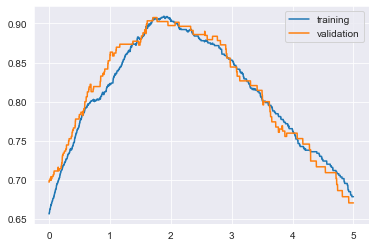

In [6]:
# We will plot the results of recall and f1 vs m
plt.plot(df_optim['m'], df_optim['f1'], label='training')
plt.plot(df_optim['m'], df_optim['f1_test'], label='validation')
plt.legend()
plt.show()


In [7]:
# We will now calculate the confusion matrix for the test data using the optimized m
interval_optim = df_optim.sort_values(by='f1', ascending=False).head(1)['interval'].values[0]
df_test['leak_pred'] = (df_test['mean'] < interval_optim[0]) | (df_test['mean'] > interval_optim[1])

# We will calculate the confusion matrix using sklearn
confusion_matrix(df_test['leak'], df_test['leak_pred']),

# We will add the names for TP, TN, FP, FN

TP = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])[0][0]
TN = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])[1][1]
FP = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])[1][0]
FN = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])[0][1]

# We will print the results
ic(TP, TN, FP, FN)

# We will add some formatting to the confusion matrix
cm = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])
cm = pd.DataFrame(cm, columns=['Pred Leak', 'Pred No Leak'], index=['Real Leak', 'Real No Leak'])

# We will also add some colors to the confusion matrix
cm.style.background_gradient(cmap='Blues')

ic| TP: 97, TN: 82, FP: 11, FN: 10


,Pred Leak,Pred No Leak
Real Leak,97,10
Real No Leak,11,82


In [9]:
ic(m_optim)
ic(mean_real, std_real)
ic(interval_optim)

ic| m_optim: 1.7263452690538108
ic| mean_real: -0.13392067119737544, std_real: 0.21085167523414186
ic| interval_optim: [-0.5314555859966927, 0.2636142436019418]


[-0.5314555859966927, 0.2636142436019418]

In [12]:
m_optim = df_optim.sort_values(by='f1', ascending=False).head(1)['m'].values[0]
interval_optim = df_optim.sort_values(by='f1', ascending=False).head(1)['interval'].values[0]
interval_optim

[-0.5314555859966927, 0.2636142436019418]

### 5.3.1 Testing with manually simulated leaks
Now we will read the data simulated manually and see if we are able to succesfully detect the leaks. For this we will do the same process we did with the original data. The process needs to be repeated since we care about the mean and std of the `FUEL_ERROR_DIFF` column.

In [13]:
df_sim = pd.read_csv('data/sim_data/Simulation-Leak1-Leak2-FRBAJ3570.csv')
df_sim['FLIGHT_PHASE_COUNT'] = 8
df_sim.to_csv('data/sim_data/Simulation-Leak1-Leak2-FRBAJ3570.csv', index=False)

In [14]:
columns = ['Flight', 'MSN', 'UTC_TIME', 'FLIGHT_PHASE_COUNT', 'FW_GEO_ALTITUDE',
           'FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4',
           #'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4',
           'VALUE_FOB']

# Define the data types
columns_dtypes = {'Flight': 'str', 'MSN': 'str',
                  'FLIGHT_PHASE_COUNT': 'float16', 'FW_GEO_ALTITUDE': 'float32',
                  'FUEL_USED_1': 'float32', 'FUEL_USED_2': 'float32',
                  'FUEL_USED_3': 'float32', 'FUEL_USED_4': 'float32',
                  # 'VALUE_FUEL_QTY_FT1': 'float32', 'VALUE_FUEL_QTY_FT2': 'float32',
                  # 'VALUE_FUEL_QTY_FT3': 'float32', 'VALUE_FUEL_QTY_FT4': 'float32',
                  'VALUE_FOB': 'float64'}

value_cols = ['FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4']

df = cf.read_and_prepare('data/sim_data/Simulation-Leak1-Leak2-FRBAJ3570.csv', columns, columns_dtypes, parse_dates=['UTC_TIME'],
                             delimiter=',', altitude_filter=True)

ic(df.shape)
# Keep usable flights
df_filtered = cf.keep_usable_flights(df, 'id', value_cols, 1)

df_filtered_shape = df_filtered.shape
ic(df_filtered_shape)

# Fill missing values
df_complete = cf.fill_missing_values_all_flights(df=df_filtered)

ic('Filled missing values: COMPLETE')
# Enrich data
df_enriched = cf.add_fuel_columns(df_complete, col1='FUEL_DEPLETION',
                                  col2='FUEL_USED_TOT')
df_enriched.dropna(inplace=True)
df_enriched.to_csv('data/prep_data/prep_sim_Leak1_Leak2_FRBAJ3570.csv', index=False)

ic('Enrich data: COMPLETE')
# Statistical tests
df_tests = cf.iterate_test(df_enriched, column_name = 'FUEL_ERROR_DIFF',
                           alpha=0.05, iterable_column='id')


ic| df.shape: (54612, 10)
ic| df_filtered_shape: (54612, 10)
ic| 'Filled missing values: COMPLETE'
ic| 'Enrich data: COMPLETE'


In [15]:
df_tests['leak_pred'] = (df_tests['mean'] < interval_optim[0]) | (df_tests['mean'] > interval_optim[1])
df_tests['leak_real'] = df_tests['id'].str[0] == 'L'
df_tests[['id', 'mean', 'leak_pred', 'leak_real']]

,id,mean,leak_pred,leak_real
0,F-RBAJ_357.0,0.001031,False,False
0,L-LEAK_1.0,0.501031,True,True
0,L-LEAK_2.0,0.249973,False,True


As we can see, our model is able to detect the leaks in the simulated data. It is also able to determine that there is no leak on the first flight.

## 5.4 Optimize the interval to minimize the Cost based on business rules
Finally, we will define the optimal interval based on the business case. Since our end goal is to minimize costs associated with leak fuels and maintenance cost, it is important to take this into consideration.
The costs depend on the following scenarios:
- We identify correctly the leak (TP): 91,608
- We fail to identify a leak (FN): 387,565
- We accurately detect a lack of leak (TN): 0
- We identify a non-existing leak (FP): 51,040

In [4]:
# We will split the data into train and test
df_tests = pd.read_csv('data/sim_data/tested_simulated_flights.csv')
df_train, df_test = train_test_split(df_tests, test_size=0.2, random_state=42)

In [8]:
# Now we will optimize the interval to minimize the recall and the f1 score
# We will define the interval as the mean +- m * std, we will optimize alpha
m = np.linspace(0, 5, 5000)

df_optim = pd.DataFrame()
for i in m:
    # We will calculate the interval
    interval = [mean_real - i * std_real, mean_real + i * std_real]

    # We will calculate the predicted values for df_tests, evaluating that the mean column is between the interval
    df_train['leak_pred'] = (df_train['mean'] < interval[0]) | (df_train['mean'] > interval[1])
    df_test['leak_pred'] = (df_test['mean'] < interval[0]) | (df_test['mean'] > interval[1])

    # We will calculate the recall and the f1 score based on the leak and leak_pred columns (from sklearn)
    cost_train = np.where((df_train['leak_pred']==0) & (df_train['leak']== 0), 0,
                               np.where((df_train['leak_pred']==0) & (df_train['leak']==1), 387565,
                                        np.where((df_train['leak_pred']==1) & (df_train['leak']==0), 51040, 91608))).sum()

    cost_test = np.where((df_test['leak_pred']==0) & (df_test['leak']== 0), 0,
                                 np.where((df_test['leak_pred']==0) & (df_test['leak']==1), 387565,
                                         np.where((df_test['leak_pred']==1) & (df_test['leak']==0), 51040, 91608))).sum()


    # We will save the result of the recall, f1 and the value of i
    df_optim = df_optim.append({'m': i, 'cost_train': cost_train, 'cost_test': cost_test,
                                'interval': interval, 'mean': mean_real, 'std': std_real
                                }, ignore_index=True)

    # We will print the progress of each iteration
    progress = (i - m[0]) / (m[-1] - m[0])
    print(f'Progress: {progress:.2%}', end='\r')

# We will get the m values that maximize the f1 score
m_optim = df_optim.sort_values(by='cost_test', ascending=True).head(1)['m'].values[0]
df_optim.sort_values(by='cost_test', ascending=True).head(5)


,m,cost_train,cost_test,interval,mean,std
680,0.680136,47138950,12833607,"[-0.2773284919207366, 0.0094871495259857]",-0.133921,0.210852
677,0.677135,47189990,12833607,"[-0.27669581035872176, 0.00885446796397088]",-0.133921,0.210852
678,0.678136,47138950,12833607,"[-0.2769067042127267, 0.00906536181797582]",-0.133921,0.210852
679,0.679136,47138950,12833607,"[-0.27711759806673164, 0.00927625567198076]",-0.133921,0.210852
681,0.681136,47138950,12833607,"[-0.2775393857747415, 0.00969804337999064]",-0.133921,0.210852


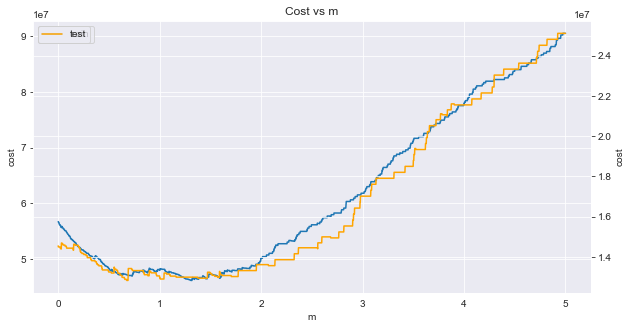

In [10]:
# We will plot the results of recall and f1 vs m, we will plot the second plot in another axis
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(df_optim['m'], df_optim['cost_train'], label='train')
ax.set_xlabel('m')
ax.set_ylabel('cost')
ax.set_title('Cost vs m')
ax.legend()
ax2 = ax.twinx()
ax2.plot(df_optim['m'], df_optim['cost_test'], label='test', color='orange')
ax2.set_ylabel('cost')
ax2.legend()
plt.show()


In [12]:
# We will now calculate the confusion matrix for the test data using the optimized m
interval_optim = df_optim.sort_values(by='cost_test', ascending=True).head(1)['interval'].values[0]
df_test['leak_pred'] = (df_test['mean'] < interval_optim[0]) | (df_test['mean'] > interval_optim[1])

# We will calculate the confusion matrix using sklearn
confusion_matrix(df_test['leak'], df_test['leak_pred']),

# We will add the names for TP, TN, FP, FN

TP = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])[0][0]
TN = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])[1][1]
FP = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])[1][0]
FN = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])[0][1]

# We will print the results
ic(TP, TN, FP, FN)

# We will add some formatting to the confusion matrix
cm = confusion_matrix(df_test['leak'], df_test['leak_pred'], labels=[True, False])
cm = pd.DataFrame(cm, columns=['Pred Leak', 'Pred No Leak'], index=['Real Leak', 'Real No Leak'])

# We will also add some colors to the confusion matrix
cm.style.background_gradient(cmap='Blues')

ic| TP: 104, TN: 51, FP: 42, FN: 3


,Pred Leak,Pred No Leak
Real Leak,104,3
Real No Leak,42,51


In [13]:
ic(m_optim)
ic(mean_real, std_real)
ic(interval_optim)

ic| m_optim: 0.6801360272054411
ic| mean_real: -0.13392067119737544, std_real: 0.21085167523414186
ic| interval_optim: [-0.2773284919207366, 0.0094871495259857]


[-0.2773284919207366, 0.0094871495259857]

In [14]:
m_optim = df_optim.sort_values(by='cost_test', ascending=True).head(1)['m'].values[0]
interval_optim = df_optim.sort_values(by='cost_test', ascending=True).head(1)['interval'].values[0]
interval_optim

[-0.2773284919207366, 0.0094871495259857]

### 5.4.1 Testing with manually simulated leaks
Now we will read the data simulated manually and see if we are able to succesfully detect the leaks. For this we will do the same process we did with the original data. The process needs to be repeated since we care about the mean and std of the `FUEL_ERROR_DIFF` column.

In [15]:
df_sim = pd.read_csv('data/sim_data/Simulation-Leak1-Leak2-FRBAJ3570.csv')
df_sim['FLIGHT_PHASE_COUNT'] = 8
df_sim.to_csv('data/sim_data/Simulation-Leak1-Leak2-FRBAJ3570.csv', index=False)

In [16]:
columns = ['Flight', 'MSN', 'UTC_TIME', 'FLIGHT_PHASE_COUNT', 'FW_GEO_ALTITUDE',
           'FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4',
           #'VALUE_FUEL_QTY_FT1', 'VALUE_FUEL_QTY_FT2', 'VALUE_FUEL_QTY_FT3', 'VALUE_FUEL_QTY_FT4',
           'VALUE_FOB']

# Define the data types
columns_dtypes = {'Flight': 'str', 'MSN': 'str',
                  'FLIGHT_PHASE_COUNT': 'float16', 'FW_GEO_ALTITUDE': 'float32',
                  'FUEL_USED_1': 'float32', 'FUEL_USED_2': 'float32',
                  'FUEL_USED_3': 'float32', 'FUEL_USED_4': 'float32',
                  # 'VALUE_FUEL_QTY_FT1': 'float32', 'VALUE_FUEL_QTY_FT2': 'float32',
                  # 'VALUE_FUEL_QTY_FT3': 'float32', 'VALUE_FUEL_QTY_FT4': 'float32',
                  'VALUE_FOB': 'float64'}

value_cols = ['FUEL_USED_1', 'FUEL_USED_2', 'FUEL_USED_3', 'FUEL_USED_4']

df = cf.read_and_prepare('data/sim_data/Simulation-Leak1-Leak2-FRBAJ3570.csv', columns, columns_dtypes, parse_dates=['UTC_TIME'],
                             delimiter=',', altitude_filter=True)

ic(df.shape)
# Keep usable flights
df_filtered = cf.keep_usable_flights(df, 'id', value_cols, 1)

df_filtered_shape = df_filtered.shape
ic(df_filtered_shape)

# Fill missing values
df_complete = cf.fill_missing_values_all_flights(df=df_filtered)

ic('Filled missing values: COMPLETE')
# Enrich data
df_enriched = cf.add_fuel_columns(df_complete, col1='FUEL_DEPLETION',
                                  col2='FUEL_USED_TOT')
df_enriched.dropna(inplace=True)
df_enriched.to_csv('data/prep_data/prep_sim_Leak1_Leak2_FRBAJ3570.csv', index=False)

ic('Enrich data: COMPLETE')
# Statistical tests
df_tests = cf.iterate_test(df_enriched, column_name = 'FUEL_ERROR_DIFF',
                           alpha=0.05, iterable_column='id')


ic| df.shape: (54612, 10)
ic| df_filtered_shape: (54612, 10)
ic| 'Filled missing values: COMPLETE'
ic| 'Enrich data: COMPLETE'


In [17]:
df_tests['leak_pred'] = (df_tests['mean'] < interval_optim[0]) | (df_tests['mean'] > interval_optim[1])
df_tests['leak_real'] = df_tests['id'].str[0] == 'L'
df_tests[['id', 'mean', 'leak_pred', 'leak_real']]

,id,mean,leak_pred,leak_real
0,F-RBAJ_357.0,0.001031,False,False
0,L-LEAK_1.0,0.501031,True,True
0,L-LEAK_2.0,0.249973,True,True


In [54]:
m_optim

0.6801360272054411

In [55]:
interval_optim

[-1.1881790473680849, 0.9203377049733339]

As we can see, our model is able to detect the leaks in the simulated data. It is also able to determine that there is no leak on the first flight.